# Monte Carlo Methods

En este laboratorio vamos a explorar los métodos de Monte Carlo (Capítulo 5 del libro de Sutton y Barto). Para esto, vamos a volver a utilizar un ambiente definido en OpenAi gym (https://gym.openai.com/), es el caso esta vez de otro ambitente sencillo: el juego de Blackjack. El ambitente esta inspirado por el ejemplo 5.1 del libro, ya esta incluido en gym, por no que no es necesario crearlo desde cero. 

***
### Juego de Blackjack

Es un juego de cartas donde el objetivo es obtener cartas que sumen lo más cercano a 21 posible, sin pasarnos. Jugamos contra un dealer fijo unicamente.

Reglas:
   
- Las cartas con figuras (Jotas, Reinas y Reyes) tienen valor de 10.
- Los Ases pueden valer 11 ó 1, cuando vale 11 se lo llama "usable".
- En este caso jugamos con un mazo infinito (con reemplazo).
- El dealer comienza con una carta boca arriba y una boca abajo.
- El jugador puede pedir una carta (HIT) hasta que decida quedarse (STICK) o exceeda los 21 puntos (BUST).
- Cuando el jugador de queda (STICK), el dealer muestra su carta boca abajo y pide cartas hasta que su suma sea 17 o más.
- Si el dealer se pasa de 21, el jugador gana. En caso contrario, gana quien tenga la suma más cerca de 21.

Ambiente:
- La reward por perder es -1, por ganar es +1 y por pedir carta es 0.
- Cada observacion es una tupla que tiene: 
    - la suma del jugador
    - la carta boca arriba del dealer (1-10 donde 1 es un As)
    - True o False si el jugador tiene un As usable o no

***

### A entregar:

- Notebook con solución a los algoritmos presentados (hecho en clase)
- Analisis de la funcion de valor estimada para distinto número de episodios a visitar (ej: 100, 1000, 10000, 50000). Se busca que puedan demostrar entendimiento del algoritmo y sus resultados (Esperamos gráficas y analisis de las mismas). 
- Estimaciones de funcion de valor para otras dos politicas definidas por el estudiante. 

In [1]:
# Imports necesarios
import gym
import numpy as np
from collections import defaultdict

# Creacion del ambiente
env = gym.make('Blackjack-v0')

# Acciones: 0 = Stick, 1 = HIT
print(env.observation_space)


obs = env.reset()

print(f"Jugador: {obs[0]}, Dealer: {obs[1]}, As usable: {obs[2]} ")


nueva_obs, reward, done, _ = env.step(0)

print(f"Nuevo estado: {nueva_obs}, Recompensa: {reward}, Estado Final: {done}")

Tuple(Discrete(32), Discrete(11), Discrete(2))
Jugador: 19, Dealer: 7, As usable: False 
Nuevo estado: (19, 7, False), Recompensa: -1.0, Estado Final: True


## El algoritmo que vamos a implementar

Vamos a comenzar con el algoritmo 5.1 del libro: `First Visit MC prediction` para estimar la función de valor de una política arbitraria. 

![Image](https://marcinbogdanski.github.io/rl-sketchpad/RL_An_Introduction_2018/assets/0501_FV_MC_Pred.png)

En este caso vamos a querer evaluar una politica que se queda si el jugador tiene un valor mayor o igual a 19, y pide cartas en caso contrario. 


In [2]:
STICK = 0
HIT = 1
        
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    return STICK if score >= 19 else HIT

In [3]:
def generate_episode(policy, env):
    states, actions, rewards = [], [], []
    
    observation = env.reset()
    done = False
    while not done:
        states.append(observation)
        action = sample_policy(observation)
        actions.append(action)

        observation, reward, done, info = env.step(action)
        rewards.append(reward)

    return states, actions, rewards

In [4]:
generate_episode(sample_policy, env)

([(12, 3, False), (19, 3, False)], [1, 0], [0, -1.0])

In [5]:
def first_visit_mc_prediction(policy, env, number_episodes, gamma=1):
    V = defaultdict(float)
    returns = {} 
    
    for ep_idx in range(number_episodes):
        states, actions, rewards = generate_episode(policy, env)

        G = 0
        # Recordar que: range(start, stop, step)
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            G = gamma*G + R
            
            current_state = states[t]
            
            if current_state not in states[:t]:
                state_returns = returns[current_state] if current_state in returns else []
                state_returns.append(G)
                returns[current_state] = state_returns
                
                V[current_state] = np.mean(returns[current_state])
    
    return V  

In [6]:
value = first_visit_mc_prediction(sample_policy, env, number_episodes=50000)
for i in range(10):
    print(value.popitem())

((12, 2, True), 0.1)
((4, 2, False), -0.13043478260869565)
((12, 5, True), -0.10714285714285714)
((12, 3, True), -0.2727272727272727)
((13, 6, True), -0.16666666666666666)
((20, 7, True), 0.7763157894736842)
((4, 3, False), -0.3333333333333333)
((4, 4, False), -0.28)
((12, 4, True), 0.14285714285714285)
((12, 1, True), -0.55)


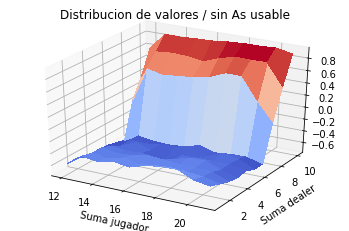

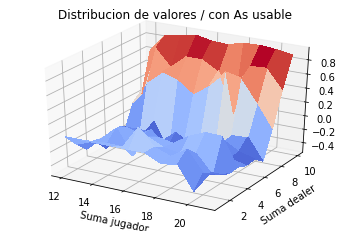

In [7]:
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_value_distribution(value):
    min_x = min(k[0] for k in value.keys())
    max_x = max(k[0] for k in value.keys())
    min_y = min(k[1] for k in value.keys())
    max_y = max(k[1] for k in value.keys())

    player_sum = np.arange(min_x, max_x + 1)
    dealer_show = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(player_sum, dealer_show)

    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = value[player, dealer, ace]
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    plt.title("Distribucion de valores / sin As usable")
    plt.xlabel("Suma jugador")
    plt.ylabel("Suma dealer")
    ax.plot_surface(X, Y, state_values[:, :, 0].T, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    plt.show()

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    plt.title("Distribucion de valores / con As usable")
    plt.xlabel("Suma jugador")
    plt.ylabel("Suma dealer")
    ax.plot_surface(X, Y, state_values[:, :, 1].T, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    plt.show()
    

plot_value_distribution(value)

# De aca para abajo me parece mucho y medio dificil...
# No lo pondría

![Image](http://incompleteideas.net/book/first/ebook/pseudotmp5.png)

In [8]:
class Policy:
    """
    Implements an epsilon-soft policy, one that returs a probability distribution for each possible action.
    
    Params
    ------
        Q: dictionary of state-action keys -> array of returns.
        number_actions: number of possible actions in the env.
        epsilon: exploration parameter where 1 explores all the time and 0 is greedy. 
    """
    
    def __init__(self, Q, number_actions, epsilon=0.1):
        self.Q = Q
        self.number_actions = number_actions
        self.epsilon = epsilon
    
    def __call__(self, observation):
        A = np.ones(self.number_actions) * self.epsilon / self.number_actions
        best_action = np.argmax(self.Q[observation])
        A[best_action] += (1.0 - self.epsilon)
        return A
    
    def update(self, new_Q):
        self.Q = new_Q

In [9]:
def monte_carlo_control(env, num_episodes, gamma=.99, epsilon=0.1, max_episode_steps=100):
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # To make it more memory efficient
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    policy = Policy(Q, env.action_space.n)
    
    for ep_idx in range(num_episodes):
        
        # Generate an episode following policy (a)
        state = env.reset()
        episode = []
        for t in range(max_episode_steps):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
    
        # (b) Update the returns for each epsisode
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
            
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
            
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
        
        # (c) Update the policy
        policy.update(Q)
        
        return Q, policy        

In [10]:
monte_carlo_control(env, 10)

(defaultdict(<function __main__.monte_carlo_control.<locals>.<lambda>()>,
             {(21, 1, True): array([1., 0.])}),
 <__main__.Policy at 0x7f810fe2dcc0>)